## Totale N.
### Esercizio 3 punto 1
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [18]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import pygraphviz as pygv
import os
from IPython.display import SVG, display
import math
import itertools

In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [38]:
class args:
    filename = "graph.gml"
    scale = 40
    figsize = 5,5

In [21]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [22]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()

In [23]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


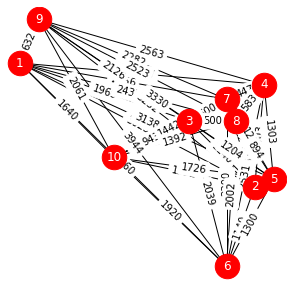

In [37]:
DrawInitG(G, withedges=True)

In [25]:
mst = gb.Model()

# Decision Variables
x = mst.addVars(G.edges(),\
                obj=[G[u][v]['cost'] for u,v in G.edges()],\
                ub = 1.0,\
                vtype=gb.GRB.BINARY, name='x')

# Cardinality constraint
mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

# Root degree constraint
root = 1
rootdeg = 3
mst.addConstr(gb.quicksum([x[u,v] if (u,v) in x else x[v,u] for u,v in G.edges(root)]), \
                  sense='<=', rhs=rootdeg, name='RootDegree')


mst.update()
mst.write('mst.lp')

Academic license - for non-commercial use only - expires 2021-07-30
Using license file /opt/gurobi/gurobi.lic


In [26]:
mst.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2 rows, 45 columns and 54 nonzeros
Model fingerprint: 0xc34c4c88
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 9e+00]
Found heuristic solution: objective 11810.000000
Presolve removed 0 rows and 28 columns
Presolve time: 0.00s
Presolved: 2 rows, 17 columns, 26 nonzeros
Found heuristic solution: objective 5016.0000000
Variable types: 0 continuous, 17 integer (16 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 5016 11810 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.016000000000e+03, best bound 5.016000000000e+03, gap 0.0000%


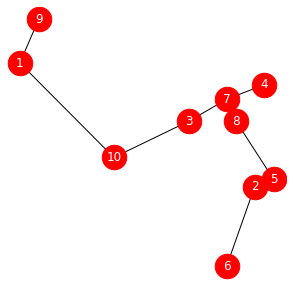

In [39]:
DrawSol(G,x)

## Data needed to the callback

Our callback needs: 
   1. The graph $G$
   2. The variables $x$
   3. The separation routine
   4. The number of SECs generated so far
 
The above data are added to the ``mst`` Model. Note the ``_`` before the data name

In [28]:
mst._graph = G
mst._vars = x
mst._nSEC = 0

In [29]:
def SECcallback (model, where):
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        x_at_node = model.cbGetSolution(x)
        G = model._graph
                
        sol_G = G.edge_subgraph([(u,v) for (u,v) in G.edges() 
                                 if math.isclose(x_at_node[u,v], 1.0, abs_tol=1E-3)])
        
        # Check if sol_G is connected
        for cc in nx.connected_components(sol_G):
            if len(cc) < G.number_of_nodes():
                if len(cc) > 2:
                    if sol_G.subgraph(cc).number_of_edges() > (len(cc) - 1):
                        
                        seclhs = gb.quicksum(x[u,v] if (u,v) in x else x[v,u] 
                                             for u,v in G.subgraph(cc).edges())
                        
                        model.cbLazy(seclhs <= len(cc) - 1)
                        model._nSEC += 1

                        print (f"SEC --> {G.subgraph(cc).nodes()}")
        print ('_'*50)  

In [30]:
mst.reset()
mst.Params.OutputFlag = 1
mst.Params.lazyConstraints = 1
mst.optimize(SECcallback)

Discarded solution information
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2 rows, 45 columns and 54 nonzeros
Model fingerprint: 0xc34c4c88
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 9e+00]
SEC --> [2, 3, 4, 5, 6, 7, 8, 9, 10]
__________________________________________________
SEC --> [6, 7, 8, 9, 10]
__________________________________________________
Presolve time: 0.00s
Presolved: 2 rows, 45 columns, 54 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
SEC --> [6, 7, 8, 9, 10]
__________________________________________________

Root relaxation: obj

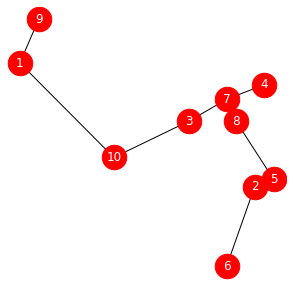

In [31]:
DrawSol(G, x)